In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
%matplotlib inline
sns.set()

In [2]:
data = data_adsmart = pd.read_csv("AdSmartABdata.csv")

#Data visualization

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8077 entries, 0 to 8076
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   experiment   8077 non-null   object
 1   date         8077 non-null   object
 2   hour         8077 non-null   int64 
 3   device_make  8077 non-null   object
 4   platform_os  8077 non-null   int64 
 5   browser      8077 non-null   object
 6   yes          8077 non-null   int64 
 7   no           8077 non-null   int64 
dtypes: int64(4), object(4)
memory usage: 504.9+ KB


#Feature engeenering

In [4]:
data.drop('auction_id', axis=1, inplace=True)

### Drop rows with no response

In [22]:
data = data[(data['yes'] != 0) | data['no'] != 0]

In [25]:
data.shape

(1243, 8)

### Encoding catagorical data

In [27]:
from sklearn import preprocessing 
# label_encoder object knows how to understand word labels. 
label_encoder = preprocessing.LabelEncoder() 
# Encode labels in all columns. 
data['experiment']= label_encoder.fit_transform(data['experiment'])
data['date']= label_encoder.fit_transform(data['date'])
data['device_make']= label_encoder.fit_transform(data['device_make'])
data['browser']= label_encoder.fit_transform(data['browser'])

In [28]:
data.head()

,experiment,date,hour,device_make,platform_os,browser,yes,no
2,1,2,2,4,6,2,0,1
16,1,1,16,13,6,1,1,0
20,1,3,8,13,6,1,0,1
23,0,5,4,43,6,4,1,0
27,0,0,15,13,6,1,0,1


### Scale variables

In [29]:
from sklearn.preprocessing import MinMaxScaler
scaling = MinMaxScaler()
data[:6] = scaling.fit_transform(data[:6])

In [30]:
data.head()

,experiment,date,hour,device_make,platform_os,browser,yes,no
2,1.0,0.285714,0.000000,0.000000,0.0,0.333333,0.0,1.0
16,1.0,0.142857,1.000000,0.230769,0.0,0.000000,1.0,0.0
20,1.0,0.428571,0.428571,0.230769,0.0,0.000000,0.0,1.0
23,0.0,0.714286,0.142857,1.000000,0.0,1.000000,1.0,0.0
27,0.0,0.000000,0.928571,0.230769,0.0,0.000000,0.0,1.0


In [31]:
train, validate, test = np.split(data.sample(frac=1), [int(.7*len(data)), int(.9*len(data))])

In [32]:
x_train = train[['experiment', 'date', 'hour',  'platform_os', 'browser']]
y = train['yes']

In [33]:
x_test = test[['experiment', 'date', 'hour',  'platform_os', 'browser']]
y_test = test['yes']

In [34]:
x_validate = validate[['experiment', 'date', 'hour', 'platform_os', 'browser']]
y_validate = validate['yes']

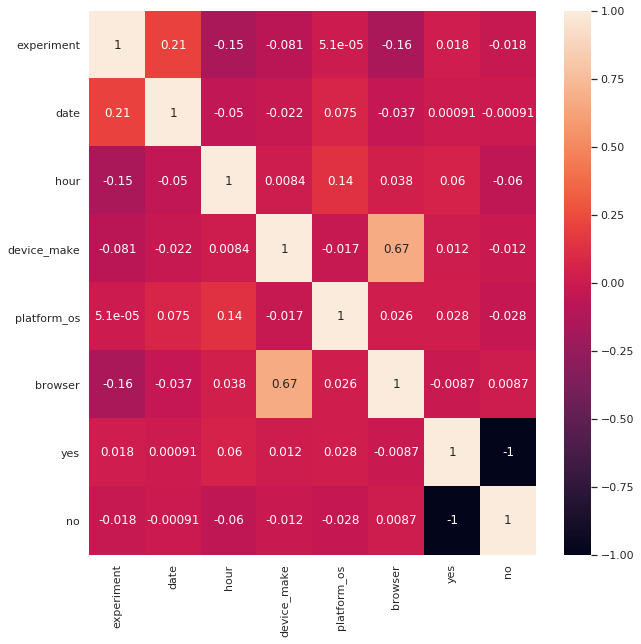

In [35]:
corrmat = data.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10,10))
#plot heat map
g = sns.heatmap(data[top_corr_features].corr(), annot= True)

In [36]:
for col in data.columns:
  print(col,':', data[col].nunique(), 'labels')


experiment : 2 labels
date : 12 labels
hour : 27 labels
device_make : 116 labels
platform_os : 3 labels
browser : 9 labels
yes : 2 labels
no : 2 labels


#Modeling

In [38]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb


In [40]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
k_fold = KFold(n_splits=5, random_state=0)

##Logestic_regression

In [44]:
log_model = LogisticRegression()
log_model.fit(x_train,y)
print(cross_val_score(log_model, x_train, y,cv=k_fold, scoring= 'accuracy').mean())

0.5379310344827587


In [48]:
from sklearn.metrics import log_loss,roc_curve
model = log_model
# predict probabilities
probs = model.predict_proba(x_validate)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate log loss
loss = log_loss(y_validate, probs)
loss

0.6922226476008595

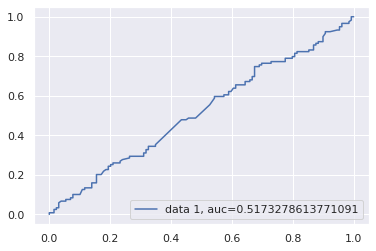

In [53]:
from sklearn.metrics import roc_curve, roc_auc_score
y_pred_proba = log_model.predict_proba(x_validate)[::,1]
fpr, tpr, _ = roc_curve(y_validate,  y_pred_proba)
auc = roc_auc_score(y_validate, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [56]:
feat_importance = pd.Series(log_model.feature_importances_, index=x_train.columns)
feat_importance.plot(kind='barh')
plt.show()

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

In [57]:
prediction = log_model.predict(x_test)

In [58]:
predicted_values = pd.DataFrame({
           "experiment" : test['experiment'],
           "yes" : prediction})

In [66]:
predicted_values.head()

,experiment,yes
5248,0.0,0.0
4168,0.0,0.0
3621,0.0,0.0
362,0.0,0.0
6782,0.0,0.0


In [60]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, prediction)
cnf_matrix

array([[73,  0],
       [52,  0]])

##Decision tree

In [67]:
dt = DecisionTreeClassifier()
dt.fit(x_train,y)
print(cross_val_score(log_model, x_train, y,cv= 5, scoring= 'accuracy').mean())

0.5333333333333334


In [68]:
from sklearn.metrics import log_loss
model = dt
# predict probabilities
probs = model.predict_proba(x_test)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate log loss
loss = log_loss(y_test, probs)
loss

10.734845077467465

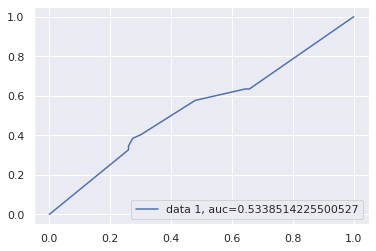

In [69]:
y_pred_proba = dt.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [71]:
feat_importance = pd.Series(log_model.feature_importances_, index=x_train.columns)
feat_importance.plot(kind='barh')
plt.show()

AttributeError: 'LogisticRegression' object has no attribute 'feature_importances_'

In [72]:
prediction = dt.predict(x_test)

In [73]:
predicted_values = pd.DataFrame({
           "experiment" : test['experiment'],
           "yes" : prediction})

In [74]:
predicted_values.head()

,experiment,yes
5248,0.0,1.0
4168,0.0,1.0
3621,0.0,1.0
362,0.0,0.0
6782,0.0,0.0


In [75]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, prediction)
cnf_matrix

array([[51, 22],
       [31, 21]])

##XGBoost

In [76]:
data_dmatrix = xgb.DMatrix(data=x_train,label=y_train)
xg_reg = xgb.XGBClassifier()
xg_reg.fit(x_train,y_train)
print(cross_val_score(xg_reg, x_train, y_train,cv= 5, scoring= 'accuracy').mean())


NameError: name 'y_train' is not defined

In [77]:
from sklearn.metrics import log_loss
model = xg_reg
# predict probabilities
probs = model.predict_proba(x_test)
# keep the predictions for class 1 only
probs = probs[:, 1]
# calculate log loss
loss = log_loss(y_test, probs)
loss

NameError: name 'xg_reg' is not defined

In [78]:
y_pred_proba = xg_reg.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

NameError: name 'xg_reg' is not defined

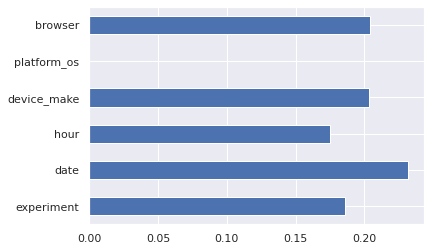

In [ ]:
feat_importance = pd.Series(xg_reg.feature_importances_, index=x_train.columns)
feat_importance.plot(kind='barh')
plt.show()

In [ ]:
prediction = xg_reg.predict(x_test)

In [ ]:
submission = pd.DataFrame({
    "experiment" : test['experiment'],
    "converted" : prediction
})

In [ ]:
submission.head()

,experiment,converted
7941,1.0,0.0
129,0.0,0.0
3781,1.0,0.0
636,1.0,0.0
4638,1.0,0.0


In [ ]:
from sklearn import metrics
cnf_matrix = metrics.confusion_matrix(y_test, prediction)
cnf_matrix

array([[747,   0],
       [ 61,   0]])